# Discontinuity Detector use example
  This algorithm uses LPC and some heuristics to detect discontinuities in an audio signal. [1].
  
      References:
        [1] Mühlbauer, R. (2010). Automatic Audio Defect Detection.

In [4]:
import essentia.standard as es
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio 
from essentia import array as esarr

plt.style.use('seaborn-pastel')
plt.rcParams["figure.figsize"] =(12,9)

In [5]:
def compute(x, frame_size=1024, hop_size=512, **kwargs):
    discontinuityDetector = es.DiscontinuityDetector(frameSize=frame_size,
                                                     hopSize=hop_size, 
                                                     **kwargs)
    locs = []
    amps = []
    for idx, frame in enumerate(es.FrameGenerator(x, frameSize=frame_size,
                                                  hopSize=hop_size, startFromZero=True)):
        frame_locs, frame_ampls = discontinuityDetector(frame)

        for l in frame_locs:
            locs.append((l + hop_size * idx) / 44100.)
        for a in frame_ampls:
            amps.append(a)

    return locs, amps

# Generating some discontinuities examples

Let's start by degrading some audio files with some discontinuities. Discontinuities are generally occasioned by hardware issues in the process of recording or copying. Let's simulate this by removing a random number of samples from the input audio file. 

In [22]:
    def testRegression(self, frameSize=512, hopSize=256):
        fs = 44100

        audio = MonoLoader(filename=join(testdata.audio_dir,
                           'recorded/cat_purrrr.wav'),
                           sampleRate=fs)()

        originalLen = len(audio)
        startJump = originalLen / 4
        groundTruth = [startJump / float(fs)]

        # make sure that the artificial jump produces a prominent discontinuity
        if audio[startJump] > 0:
            end = next(idx for idx, i in enumerate(audio[startJump:]) if i < -.3)
        else:
            end = next(idx for idx, i in enumerate(audio[startJump:]) if i > .3)

        endJump = startJump + end
        audio = esarr(np.hstack([audio[:startJump], audio[endJump:]]))

        frameList = []
        discontinuityDetector = self.InitDiscontinuityDetector(
                                    frameSize=frameSize, hopSize=hopSize,
                                    detectionThreshold=10)

        for idx, frame in enumerate(FrameGenerator(
                                    audio, frameSize=frameSize,
                                    hopSize=hopSize, startFromZero=True)):
            locs, _ = discontinuityDetector(frame)
            if not len(locs) == 0:
                for loc in locs:
                    frameList.append((idx * hopSize + loc) / float(fs))

        self.assertAlmostEqualVector(frameList, groundTruth, 1e-7)

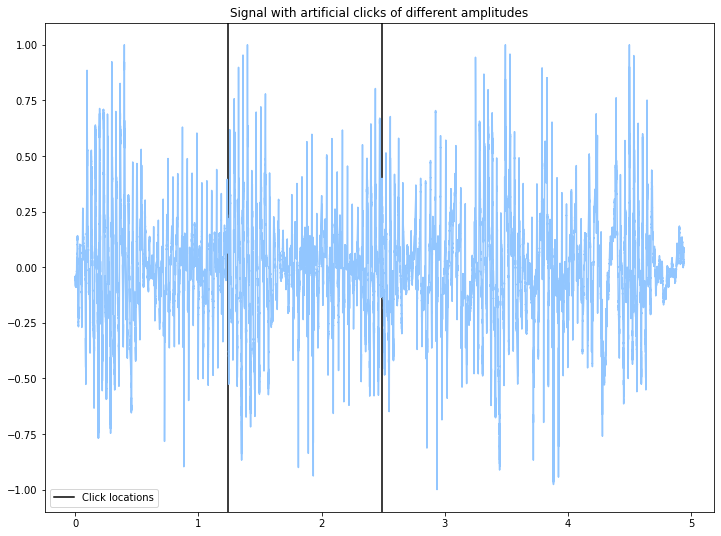

In [25]:
fs = 44100.

audio_dir = '../../audio/'
audio = es.MonoLoader(filename='../../../test/audio/recorded/cat_purrrr.wav', sampleRate=fs)()

originalLen = len(audio)
startJumps = np.array([int(i) for i in [originalLen / 4, originalLen / 2]])
groundTruth = startJumps / float(fs)

for startJump in startJumps:
    # make sure that the artificial jump produces a prominent discontinuity
    if audio[startJump] > 0:
        end = next(idx for idx, i in enumerate(audio[startJump:]) if i < -.3)
    else:
        end = next(idx for idx, i in enumerate(audio[startJump:]) if i > .3)

    endJump = startJump + end
    audio = esarr(np.hstack([audio[:startJump], audio[endJump:]]))


for point in groundTruth:
    l1 = plt.axvline(point, color='black')

times = np.linspace(0, len(audio) / fs, len(audio))
plt.plot(times, audio)
plt.title('Signal with artificial clicks of different amplitudes')
l1.set_label('Click locations')
plt.legend()


Lets listen to the clip to have an idea on how audible the discontinuities  are

In [26]:
Audio(audio, rate=fs)

# The algorithm
This algorithm outputs the starts and ends timestapms of the clicks. The following plots show how the algorithm performs in the previous examples


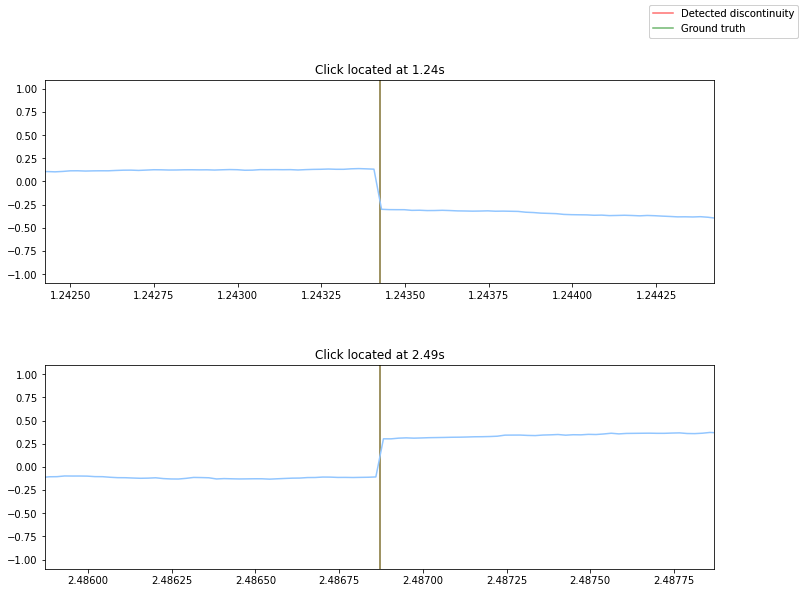

In [27]:
locs, amps = compute(audio)

fig, ax = plt.subplots(len(groundTruth))
plt.subplots_adjust(hspace=.4)
for idx, point in enumerate(groundTruth):
    l1 = ax[idx].axvline(locs[idx], color='r', alpha=.5)
    l2 = ax[idx].axvline(point, color='g', alpha=.5)
    ax[idx].plot(times, audio)
    ax[idx].set_xlim([point-.001, point+.001])
    ax[idx].set_title('Click located at {:.2f}s'.format(point))
    
    
    fig.legend((l1, l2), ('Detected discontinuity', 'Ground truth'), 'upper right')

# The parameters
this is an explanation of the most relevant parameters of the algorithm

- **detectionThreshold.** This parameter controls de detection sensibility of the algorithm  

- **kernelSize.** A scalar giving the size of the median filter window. The window has to be as small as possible to improve the whitening of the signal but big enough to skip peaky outlayers from the prediction error signal.  

- **order.** The order for the LPC. As a rule of thumb, use 2 coefficients for each format on the input signal. However, it was empirically found that modelling more than 5 formats did not improve the clip detection on music.

- **silenceThresholdder.** It makes no sense to process silent frames as even if there are events looking like discontinuities they can't be heard

- **subFrameSize.** If was found that frames that are partially silent are suitable for fake detections. This is because the audio is modelled as an autoregressive process in which discontinuities are easily detected as peaks on the prediction error. However, if the autoregressive assumption is no longer true, unexpected events can produce error peaks. Thus, a subframe window is used to mask out the silent part of the frame so they don't interfere in the autoregressive parameter estimation.

- **energyThreshold.** threshold in dB to detect silent subframes.